# Quantifying the impact of exchange rate volatility for Monero-denominated delayed payouts

Isthmus / Mitchell Krawiec-Thayer ([isthmus@getmonero.org](mailto:isthmus@getmonero.org))

Monero contributors fundraising through the [Monero community crowdfunding system](https://ccs.getmonero.org/) must provide an monero-denominated quote for services up-front, often for payout weeks or months later upon project or milestone completion. The Monero exchange rate fluctuates significantly over these timescales.

At the time of writing, most contributors need to pay their regular rent/tuition/food/etc bills in fiat currency. Exchange rate volatility resulting in loss of monero's buying power effectively reduces contributor compensation. To protect against this, proposals often include a volatility buffer. Rather than relying on gut intuition or short term market trends, this notebook analyzes exchange rate volatility over the last few years to suggest a statistically-appropriate buffer.

**This method utilizes sliding window statistics over the monero/fiat exchange rate time series.** The window width is determined by the time between quote issuance and payout. The length of the time series should be long enough to avoid recency bias, and short enough to remain representative (conditions in 2020 vary significantly from 2015). Here, we use 4 months for the window width (1 month to fundraise + 3 months to complete work), and the last 2 years for the timeseries length. 

Window width depends on each project's timeline and the timeseries length is somewhat subjective, so this research is deliberately shared as an interactive notebook. The next cell allows you to adjust the model's window width and input data:

## Set model parameters

In [1]:
days_quote_to_pay = 120; # width of sliding window
path_to_price_data = 'xmr_exchange_rate.csv';

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22});

## Import data

In [3]:
df = pd.read_csv(path_to_price_data);
df.tail() # take a peek to make sure it imported correctly

,date,USD_per_XMR
725,2020-04-11,54
726,2020-04-12,54
727,2020-04-13,53
728,2020-04-14,54
729,2020-04-15,53


## View timeseries

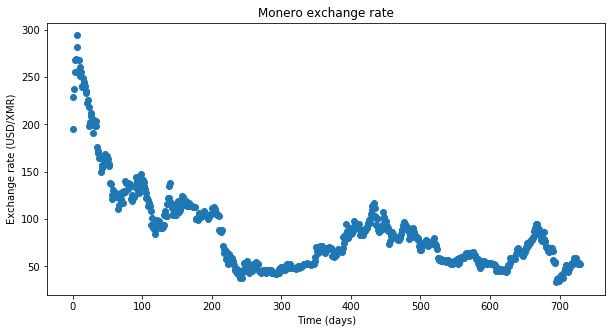

In [4]:
f = plt.figure(figsize=(10,5), facecolor='white');
plt.scatter(range(len(df)), df['USD_per_XMR']);
plt.xlabel('Time (days)');
plt.ylabel('Exchange rate (USD/XMR)');
plt.title('Monero exchange rate');

## Feature engineering

Slide a window (of width `days_quote_to_pay` over the exchange rate timeseries)

In [5]:
gain_loss_buffer = list(np.full(days_quote_to_pay, np.nan));
for r in range(len(df)-days_quote_to_pay):
    price_at_quote = df.iloc[r].USD_per_XMR;
    price_at_payout = df.iloc[r+days_quote_to_pay].USD_per_XMR;
    gain_loss_buffer.append((price_at_payout-price_at_quote)/price_at_quote*100);
    
df['gain_loss'] = gain_loss_buffer;

## Review sliding window outcomes

The below histogram shows the probability distribution of outcomes. 

A value of 0 on the x-axis indicates that the exchange rate for the payout exactly matched the exchange rate when the quote was issued 4 months prior. A negative value on the x-axis indicates that the USD/XMR ratio decreased and monero lost spending power, so a contributor responsible for fiat-denominated bills experiences a reduction in compensation. (Likewise, a positive value indicates the opposite, that monero has gained spending power over the window.)

We observe an asymmetry over the past two years, for example: contributors were 2x as likely to experience a 50% loss in compensation (red line) than a 50% increase in compensation (green line)

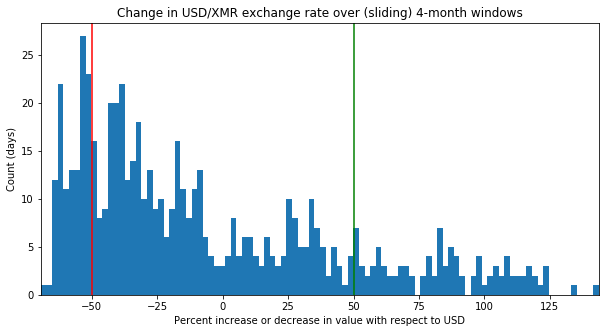

In [6]:
f = plt.figure(figsize=(10,5), facecolor='white');
plt.hist(df["gain_loss"].dropna(),bins=100);
plt.xlim((min(df['gain_loss'].dropna()),max(df['gain_loss'].dropna())));
plt.xlabel("Percent increase or decrease in value with respect to USD");
plt.ylabel('Count (days)');
plt.title('Change in USD/XMR exchange rate over (sliding) 4-month windows');
plt.axvline(x=-50, color='red');
plt.axvline(x=+50, color='green');

In addition to the probability distribution function shown above, it's also informative to view the cumulative distribution function below. The red lines highlight that **over the last 2 years, the USD/XMR exchange rate decreased over 65% of 4-month windows.** In other words, only 35% of contributors would have received a payout that covers the quoted price.

The orange lines show that an 80% likelihood of receiving a sufficent payout can be achieved with a +35% buffer.

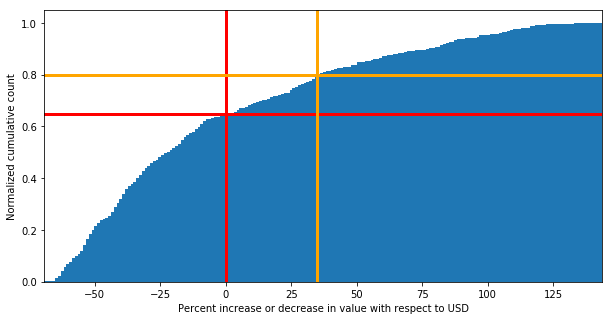

In [7]:
f = plt.figure(figsize=(10,5), facecolor='white');
plt.hist(df['gain_loss'].dropna(), bins=200, cumulative=True, density=True);
plt.xlabel("Percent increase or decrease in value with respect to USD");
plt.ylabel('Normalized cumulative count');
plt.xlim((min(df['gain_loss'].dropna()),max(df['gain_loss'].dropna())));
plt.axhline(y=0.65, color='red', linewidth=3);
plt.axvline(x=0, color='red', linewidth=3);
plt.axhline(y=0.80, color='orange', linewidth=3);
plt.axvline(x=35, color='orange', linewidth=3);

A volatility buffer is intended to protect the contributor against exchange rate decreases over the period of work.

**If the volatility buffer is set by the median value of exchange rate ratios, then we statistically expect:** 50% of contributors will experience a loss of spending power (of any magnitude) and 50% will experience a gain in spending power (of any magnitude). 

Notes: (1) If anything less than the median value is used,  there is *more than a 50% chance* that the fiat value of the quoted price will not be received upon xmr-denominated payout. (2) The median value was chosen for robustness to outliers (if the mean is used, then 1 contributor who lucks out with 150% increase cancels out 3 contributors who suffer a significant 50% loss, obscuring the fact that 3 of the 4 experienced a negative outcome)

A safer bet is median + standard deviation, in which case 74% of contributors will see an receive at least the expected payout. 

In [8]:
print('Median exchange rate ratio = ' + str(int(np.nanmedian(df['gain_loss'])))+'%');
print('Exchange rate ratio standard deviation = ' + str(int(np.nanstd(df['gain_loss'])))+'%');

Median exchange rate ratio = -22%
Exchange rate ratio standard deviation = 49%
